In this project, we will be working on weather forecasting. The dataset has been obtained from the following url:https://www.kaggle.com/grubenm/austin-weather

We are going to use the Google Colab platform for this project

In [0]:
#commenting the below 2 lines as it contains information related to my Google account
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
import os, shutil
from math import ceil, floor
from fbprophet import Prophet
import seaborn as sns
import matplotlib.ticker as ticker

In [0]:
def unzip_files(zipFilePath, unzip_directory):
  zipFile = ZipFile(zipFilePath, 'r')
  zipFile.extractall(unzip_directory)
  zipFile.close()

In [0]:
unzip_files('drive/My Drive/datasets/weather/austin-weather.zip', 'Unzipped_austin_weather_data')

In [0]:
main_df = pd.read_csv('Unzipped_austin_weather_data/austin_weather.csv')

In [6]:
main_df.head(15)

,Date,TempHighF,TempAvgF,TempLowF,DewPointHighF,DewPointAvgF,DewPointLowF,HumidityHighPercent,HumidityAvgPercent,HumidityLowPercent,SeaLevelPressureHighInches,SeaLevelPressureAvgInches,SeaLevelPressureLowInches,VisibilityHighMiles,VisibilityAvgMiles,VisibilityLowMiles,WindHighMPH,WindAvgMPH,WindGustMPH,PrecipitationSumInches,Events
0,2013-12-21,74,60,45,67,49,43,93,75,57,29.86,29.68,29.59,10,7,2,20,4,31,0.46,"Rain , Thunderstorm"
1,2013-12-22,56,48,39,43,36,28,93,68,43,30.41,30.13,29.87,10,10,5,16,6,25,0,
2,2013-12-23,58,45,32,31,27,23,76,52,27,30.56,30.49,30.41,10,10,10,8,3,12,0,
3,2013-12-24,61,46,31,36,28,21,89,56,22,30.56,30.45,30.3,10,10,7,12,4,20,0,
4,2013-12-25,58,50,41,44,40,36,86,71,56,30.41,30.33,30.27,10,10,7,10,2,16,T,
5,2013-12-26,57,48,39,39,36,33,79,63,47,30.47,30.4,30.34,10,9,7,12,3,17,0,
6,2013-12-27,60,53,45,41,39,37,83,65,47,30.46,30.39,30.34,10,9,7,7,1,11,T,
7,2013-12-28,62,51,40,43,39,33,92,64,36,30.33,30.17,30.04,10,10,7,10,2,14,T,
8,2013-12-29,64,50,36,49,41,28,92,76,60,30.31,30.1,29.99,10,10,4,17,5,24,0,
9,2013-12-30,44,40,35,31,26,21,75,60,45,30.44,30.33,30.26,10,10,10,13,5,21,0,


In [7]:
main_df.tail()

,Date,TempHighF,TempAvgF,TempLowF,DewPointHighF,DewPointAvgF,DewPointLowF,HumidityHighPercent,HumidityAvgPercent,HumidityLowPercent,SeaLevelPressureHighInches,SeaLevelPressureAvgInches,SeaLevelPressureLowInches,VisibilityHighMiles,VisibilityAvgMiles,VisibilityLowMiles,WindHighMPH,WindAvgMPH,WindGustMPH,PrecipitationSumInches,Events
1314,2017-07-27,103,89,75,71,67,61,82,54,25,30.04,29.97,29.88,10,10,10,12,5,21,0,
1315,2017-07-28,105,91,76,71,64,55,87,54,20,29.97,29.9,29.81,10,10,10,14,5,20,0,
1316,2017-07-29,107,92,77,72,64,55,82,51,19,29.91,29.86,29.79,10,10,10,12,4,17,0,
1317,2017-07-30,106,93,79,70,68,63,69,48,27,29.96,29.91,29.87,10,10,10,13,4,20,0,
1318,2017-07-31,99,88,77,66,61,54,64,43,22,30.04,29.97,29.91,10,10,10,12,4,20,0,


In [8]:
len(main_df)

1319

In [9]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 21 columns):
Date                          1319 non-null object
TempHighF                     1319 non-null int64
TempAvgF                      1319 non-null int64
TempLowF                      1319 non-null int64
DewPointHighF                 1319 non-null object
DewPointAvgF                  1319 non-null object
DewPointLowF                  1319 non-null object
HumidityHighPercent           1319 non-null object
HumidityAvgPercent            1319 non-null object
HumidityLowPercent            1319 non-null object
SeaLevelPressureHighInches    1319 non-null object
SeaLevelPressureAvgInches     1319 non-null object
SeaLevelPressureLowInches     1319 non-null object
VisibilityHighMiles           1319 non-null object
VisibilityAvgMiles            1319 non-null object
VisibilityLowMiles            1319 non-null object
WindHighMPH                   1319 non-null object
WindAvgMPH                   

In this project we are primarily going to analyse the average values of temperature, dew point, humidity, wind, visibility, sea level pressure.

In [10]:
main_df.dtypes

Date                          object
TempHighF                      int64
TempAvgF                       int64
TempLowF                       int64
DewPointHighF                 object
DewPointAvgF                  object
DewPointLowF                  object
HumidityHighPercent           object
HumidityAvgPercent            object
HumidityLowPercent            object
SeaLevelPressureHighInches    object
SeaLevelPressureAvgInches     object
SeaLevelPressureLowInches     object
VisibilityHighMiles           object
VisibilityAvgMiles            object
VisibilityLowMiles            object
WindHighMPH                   object
WindAvgMPH                    object
WindGustMPH                   object
PrecipitationSumInches        object
Events                        object
dtype: object

we will be analysing the temperature in celsius, so we need to create a new column containing the celsius values

In [0]:
main_df['TempAvgC'] = main_df.apply(lambda row: (5.0/9)*(row['TempAvgF'] - 32), axis=1)

In [12]:
main_df[['TempAvgF', 'TempAvgC']].head()

,TempAvgF,TempAvgC
0,60,15.555556
1,48,8.888889
2,45,7.222222
3,46,7.777778
4,50,10.000000


In [0]:
main_df['Date'] = pd.to_datetime(main_df['Date'], format='%Y-%m-%d')

In [0]:
df_temperature = main_df[['Date','TempAvgC']]

In [15]:
df_temperature.head()

,Date,TempAvgC
0,2013-12-21,15.555556
1,2013-12-22,8.888889
2,2013-12-23,7.222222
3,2013-12-24,7.777778
4,2013-12-25,10.000000


In [16]:
df_temperature.tail()

,Date,TempAvgC
1314,2017-07-27,31.666667
1315,2017-07-28,32.777778
1316,2017-07-29,33.333333
1317,2017-07-30,33.888889
1318,2017-07-31,31.111111


In [0]:
#we need to rename the columns to ds and y, as fbprophet expects a dataframe in this form
df_temperature.columns = ['ds','y']

In [18]:
df_temperature.head()

,ds,y
0,2013-12-21,15.555556
1,2013-12-22,8.888889
2,2013-12-23,7.222222
3,2013-12-24,7.777778
4,2013-12-25,10.000000


we will split the dataset into train and test, in order to evaluate the forecasting capability of the model

In [0]:
df_temp_train = df_temperature.iloc[0:1229]
df_temp_test = df_temperature.iloc[1229:]

In [20]:
len(df_temp_train)

1229

In [21]:
len(df_temp_test)

90

In [22]:
df_temp_train.tail()

,ds,y
1224,2017-04-28,28.333333
1225,2017-04-29,26.111111
1226,2017-04-30,18.333333
1227,2017-05-01,21.666667
1228,2017-05-02,25.000000


In [23]:
df_temp_test.head()

,ds,y
1229,2017-05-03,26.666667
1230,2017-05-04,21.111111
1231,2017-05-05,21.666667
1232,2017-05-06,22.777778
1233,2017-05-07,23.888889


In [24]:
model_temp = Prophet()
model_temp.fit(df_temp_train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [25]:
future_temp = model_temp.make_future_dataframe(periods=90)
future_temp.tail()

,ds
1314,2017-07-27
1315,2017-07-28
1316,2017-07-29
1317,2017-07-30
1318,2017-07-31


In [0]:
forecast_temp = model_temp.predict(future_temp)

In [27]:
forecast_temp.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [28]:
len(forecast_temp)

1319

In [29]:
forecast_temp[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
1309,2017-07-22,33.041691,28.177299,38.141943
1310,2017-07-23,33.054375,28.554946,38.157984
1311,2017-07-24,33.232028,28.533010,38.164241
1312,2017-07-25,33.325966,28.352537,38.128309
1313,2017-07-26,33.270973,28.553542,38.083589
1314,2017-07-27,33.234812,28.542822,38.438852
1315,2017-07-28,33.132601,28.116490,37.860288
1316,2017-07-29,33.103846,28.326838,37.759167
1317,2017-07-30,33.095092,28.213301,38.051619
1318,2017-07-31,33.256244,28.498826,37.743857


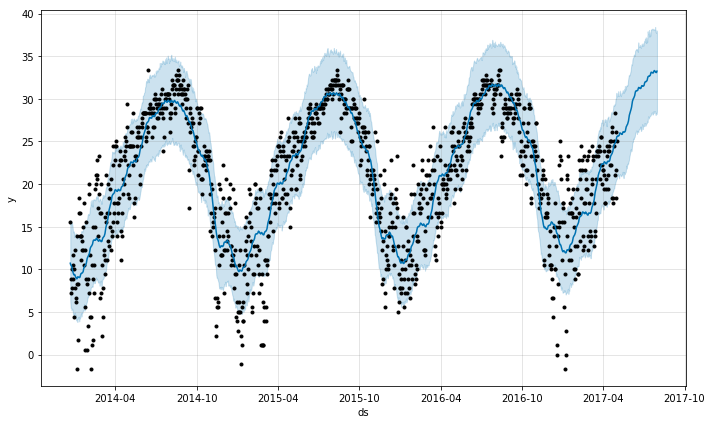

In [30]:
plot1 = model_temp.plot(forecast_temp)

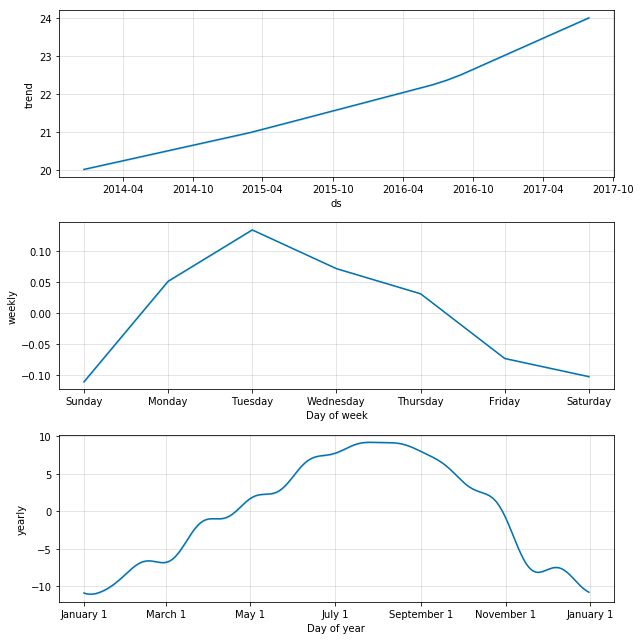

In [31]:
plot2 = model_temp.plot_components(forecast_temp)

In [0]:
analyse_temp_forecast_df = pd.concat([df_temp_test, forecast_temp[1229:]['yhat']], axis=1)

In [33]:
analyse_temp_forecast_df.tail()

,ds,y,yhat
1314,2017-07-27,31.666667,33.234812
1315,2017-07-28,32.777778,33.132601
1316,2017-07-29,33.333333,33.103846
1317,2017-07-30,33.888889,33.095092
1318,2017-07-31,31.111111,33.256244


In [0]:
analyse_temp_forecast_df.set_index('ds', inplace=True)

In [35]:
analyse_temp_forecast_df.tail()

,y,yhat
ds,,
2017-07-27,31.666667,33.234812
2017-07-28,32.777778,33.132601
2017-07-29,33.333333,33.103846
2017-07-30,33.888889,33.095092
2017-07-31,31.111111,33.256244


In [0]:
def create_line_charts(df, title, xlabel, ylabel):
  ax = sns.lineplot(data=df)
  ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
  for xtick in ax.get_xticklabels():
    xtick.set_rotation(45)
  

In [0]:
sns.set(rc={'figure.figsize':(17,8)})

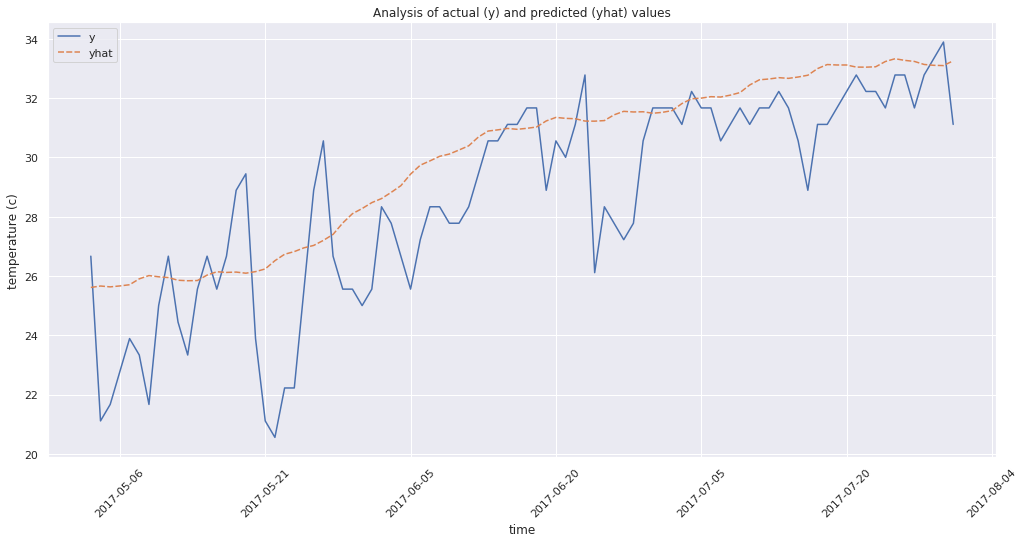

In [38]:
create_line_charts(analyse_temp_forecast_df, 'Analysis of actual (y) and predicted (yhat) values', 'time', 'temperature (c)')

In [0]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [40]:
mean_absolute_error(analyse_temp_forecast_df['y'], analyse_temp_forecast_df['yhat'])

1.7565889074200405

In [0]:
def root_mean_squared_error(y_true, y_pred):
  return np.sqrt(mean_squared_error(y_true, y_pred))

In [42]:
root_mean_squared_error(analyse_temp_forecast_df['y'], analyse_temp_forecast_df['yhat'])

2.251375535321501

Now if we want we can predict into the future, by passing the entire dataframe

In [43]:
model_temp2 = Prophet()
model_temp2.fit(df_temperature)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [44]:
future_temp2 = model_temp2.make_future_dataframe(periods=180)
future_temp2.tail()

,ds
1494,2018-01-23
1495,2018-01-24
1496,2018-01-25
1497,2018-01-26
1498,2018-01-27


In [0]:
forecast_temp2 = model_temp2.predict(future_temp2)

In [46]:
forecast_temp2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
1489,2018-01-18,13.593993,8.831861,18.252586
1490,2018-01-19,13.645530,8.790609,18.331848
1491,2018-01-20,13.675495,9.610104,18.467982
1492,2018-01-21,13.779333,9.082686,18.583211
1493,2018-01-22,14.024607,9.302299,18.704191
1494,2018-01-23,14.275174,9.344278,18.856406
1495,2018-01-24,14.391227,9.513153,19.141642
1496,2018-01-25,14.536556,9.726205,19.435287
1497,2018-01-26,14.630992,10.115748,19.253270
1498,2018-01-27,14.702208,10.073357,19.598092


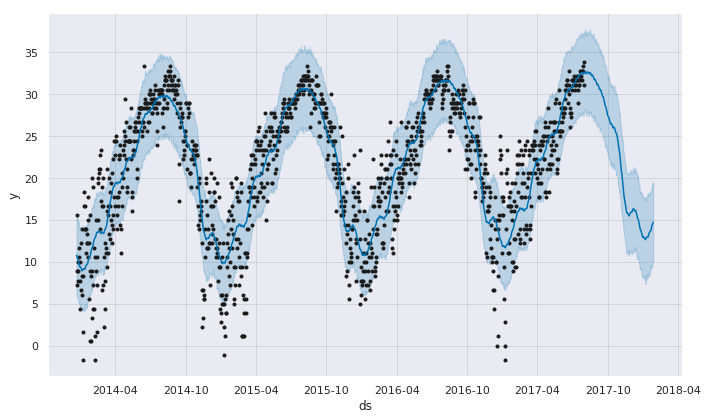

In [47]:
plot3 = model_temp2.plot(forecast_temp2)

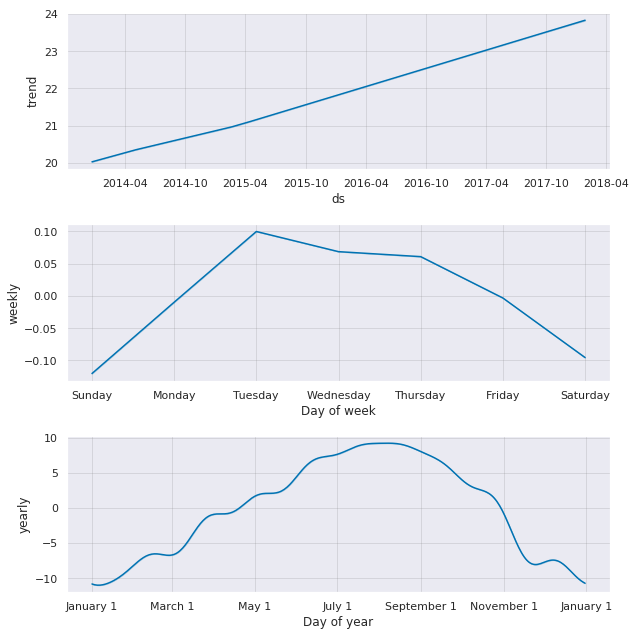

In [48]:
plot4 = model_temp2.plot_components(forecast_temp2)

In [0]:
df_humidity = main_df[['Date', 'HumidityAvgPercent']]

In [50]:
df_humidity.head()

,Date,HumidityAvgPercent
0,2013-12-21,75
1,2013-12-22,68
2,2013-12-23,52
3,2013-12-24,56
4,2013-12-25,71


In [51]:
len(df_humidity)

1319

In [0]:
df_humidity = df_humidity[df_humidity['HumidityAvgPercent'] != '-']

In [53]:
len(df_humidity)

1317

In [54]:
df_humidity.dtypes

Date                  datetime64[ns]
HumidityAvgPercent            object
dtype: object

In [0]:
df_humidity['HumidityAvgPercent'] = df_humidity['HumidityAvgPercent'].map(pd.to_numeric)

In [56]:
df_humidity.dtypes

Date                  datetime64[ns]
HumidityAvgPercent             int64
dtype: object

In [0]:
df_humidity.columns = ['ds', 'y']

In [58]:
df_humidity.head()

,ds,y
0,2013-12-21,75
1,2013-12-22,68
2,2013-12-23,52
3,2013-12-24,56
4,2013-12-25,71


In [0]:
df_humidity_train = df_humidity.iloc[0:1227]
df_humidity_test = df_humidity.iloc[1227:]

In [60]:
df_humidity_train.tail()

,ds,y
1224,2017-04-28,64
1225,2017-04-29,64
1226,2017-04-30,43
1227,2017-05-01,50
1228,2017-05-02,57


In [61]:
df_humidity_test.head()

,ds,y
1229,2017-05-03,66
1230,2017-05-04,43
1231,2017-05-05,44
1232,2017-05-06,52
1233,2017-05-07,56


In [62]:
model_humidity = Prophet()
model_humidity.fit(df_humidity_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [63]:
future_humidity = model_humidity.make_future_dataframe(periods=90)
future_humidity.tail()

,ds
1312,2017-07-27
1313,2017-07-28
1314,2017-07-29
1315,2017-07-30
1316,2017-07-31


In [0]:
forecast_humidity = model_humidity.predict(future_humidity)

In [65]:
forecast_humidity[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
1307,2017-07-22,64.205492,49.682193,78.226368
1308,2017-07-23,64.608647,49.320991,80.204899
1309,2017-07-24,62.195084,47.169557,77.705604
1310,2017-07-25,61.892488,48.078890,77.396024
1311,2017-07-26,61.427821,46.890539,75.560520
1312,2017-07-27,61.917154,47.420014,76.995028
1313,2017-07-28,62.038704,47.051339,76.379841
1314,2017-07-29,64.775591,50.332168,80.847705
1315,2017-07-30,65.449091,51.191354,79.655568
1316,2017-07-31,63.255697,48.923749,77.621925


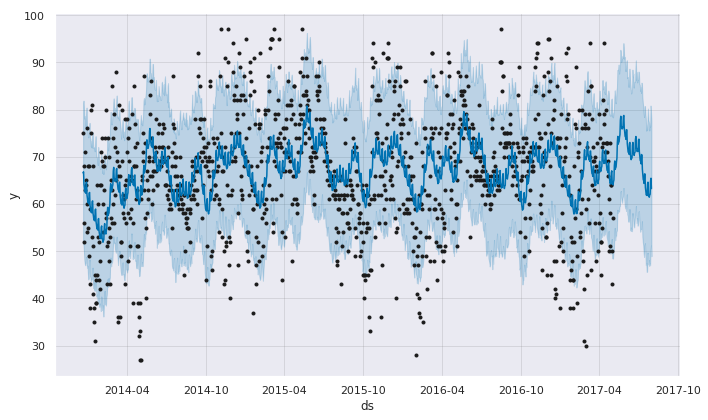

In [66]:
plot_humidity1 = model_humidity.plot(forecast_humidity)

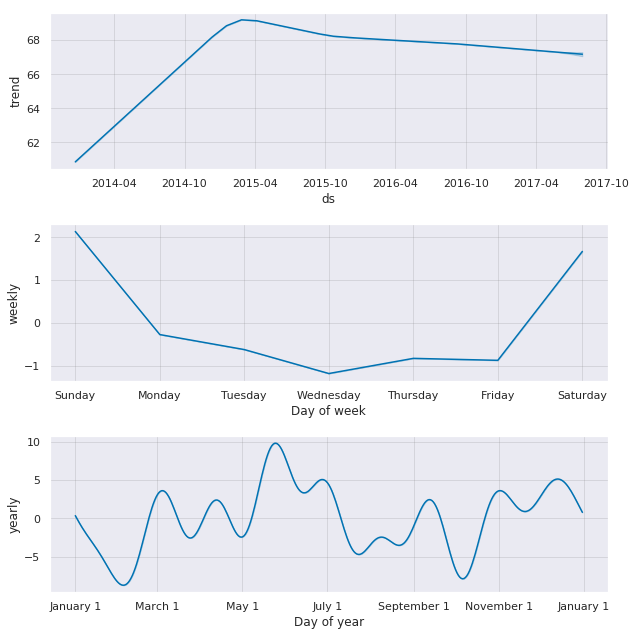

In [67]:
plot_humidity2 = model_humidity.plot_components(forecast_humidity)

In [68]:
analyse_humidity_forecast_df = pd.concat([df_humidity_test.reset_index(), forecast_humidity[1227:]['yhat'].reset_index()], axis=1)
analyse_humidity_forecast_df = analyse_humidity_forecast_df[['ds','y', 'yhat']]
analyse_humidity_forecast_df.set_index('ds', inplace=True)
analyse_humidity_forecast_df.tail()

,y,yhat
ds,,
2017-07-27,54,61.917154
2017-07-28,54,62.038704
2017-07-29,51,64.775591
2017-07-30,48,65.449091
2017-07-31,43,63.255697


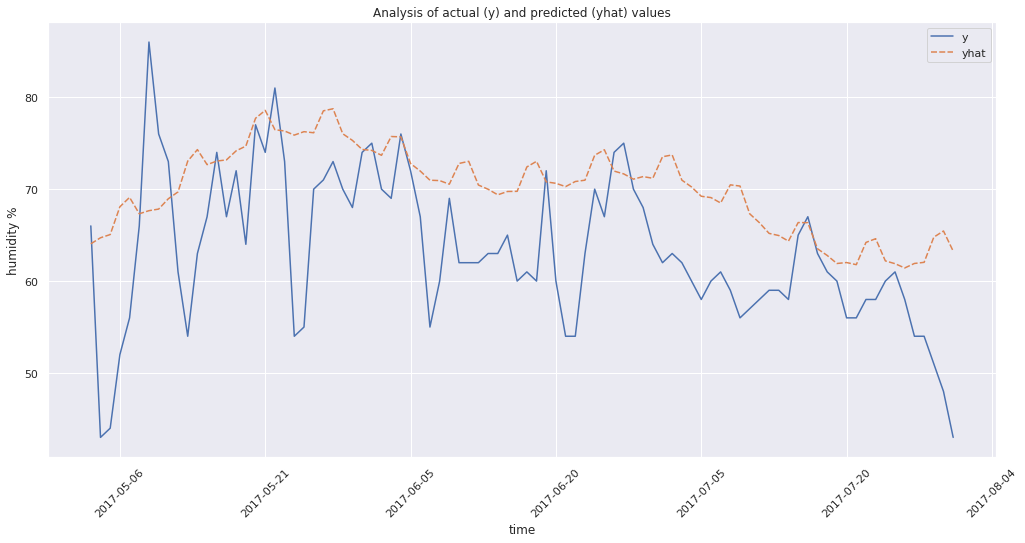

In [70]:
create_line_charts(analyse_humidity_forecast_df, 'Analysis of actual (y) and predicted (yhat) values', 'time', 'humidity %')

In [71]:
mean_absolute_error(analyse_humidity_forecast_df['y'], analyse_humidity_forecast_df['yhat'])

7.8443223004430465

In [72]:
root_mean_squared_error(analyse_humidity_forecast_df['y'], analyse_humidity_forecast_df['yhat'])

9.668386306946427

Now we can use the entire dataframe to predict into the future

In [74]:
model_humidity2 = Prophet()
model_humidity2.fit(df_humidity)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [75]:
future_humidity2 = model_humidity2.make_future_dataframe(periods=180)
future_humidity2.tail()

,ds
1492,2018-01-23
1493,2018-01-24
1494,2018-01-25
1495,2018-01-26
1496,2018-01-27


In [0]:
forecast_humidity2 = model_humidity2.predict(future_humidity2)

In [77]:
forecast_humidity2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
1487,2018-01-18,53.640616,39.805382,68.164888
1488,2018-01-19,53.303833,38.772313,67.481064
1489,2018-01-20,55.456346,40.290452,70.436898
1490,2018-01-21,55.637248,41.143342,70.402397
1491,2018-01-22,53.222638,38.518865,67.162843
1492,2018-01-23,52.650621,38.153157,66.434400
1493,2018-01-24,51.505699,37.419647,65.885956
1494,2018-01-25,51.402647,36.699064,65.784827
1495,2018-01-26,51.036366,35.721775,65.677985
1496,2018-01-27,53.174422,38.198228,67.606036


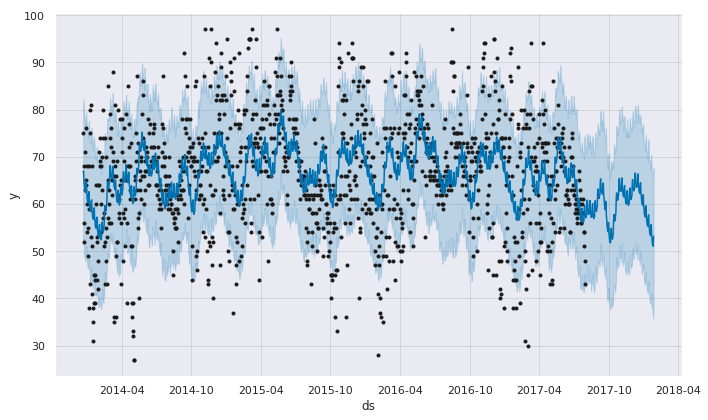

In [78]:
plot_humidity3 = model_humidity2.plot(forecast_humidity2)

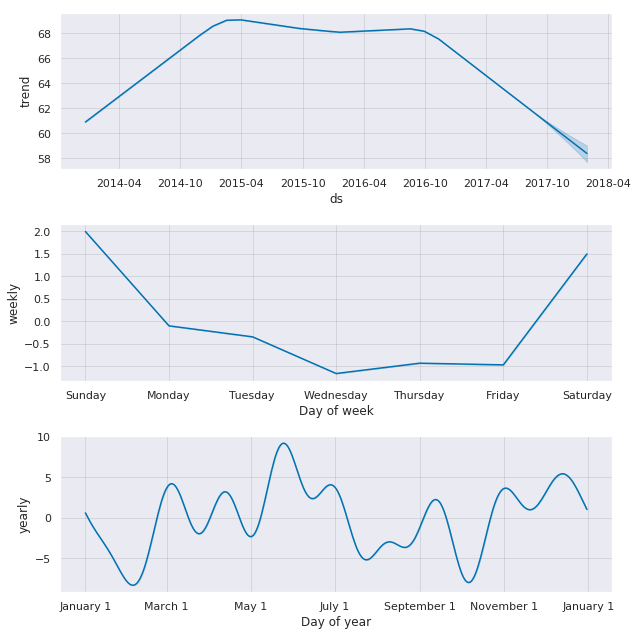

In [79]:
plot_humidity4 = model_humidity2.plot_components(forecast_humidity2)

In [0]:
df_wind = main_df[['Date', 'WindAvgMPH']]

In [81]:
len(df_wind)

1319

In [0]:
df_wind = df_wind[df_wind['WindAvgMPH'] != '-']

In [83]:
len(df_wind)

1317

In [84]:
df_wind.dtypes

Date          datetime64[ns]
WindAvgMPH            object
dtype: object

In [0]:
df_wind['WindAvgMPH'] = df_wind['WindAvgMPH'].map(pd.to_numeric)

In [86]:
df_wind.dtypes

Date          datetime64[ns]
WindAvgMPH             int64
dtype: object

In [87]:
df_wind.head()

,Date,WindAvgMPH
0,2013-12-21,4
1,2013-12-22,6
2,2013-12-23,3
3,2013-12-24,4
4,2013-12-25,2


In [0]:
df_wind.columns = ['ds', 'y']

In [89]:
df_wind.head()

,ds,y
0,2013-12-21,4
1,2013-12-22,6
2,2013-12-23,3
3,2013-12-24,4
4,2013-12-25,2


In [0]:
df_wind_train = df_wind.iloc[0:1227]
df_wind_test = df_wind.iloc[1227:]

In [91]:
df_wind_train.tail()

,ds,y
1224,2017-04-28,9
1225,2017-04-29,9
1226,2017-04-30,6
1227,2017-05-01,6
1228,2017-05-02,7


In [92]:
df_wind_test.head()

,ds,y
1229,2017-05-03,8
1230,2017-05-04,8
1231,2017-05-05,4
1232,2017-05-06,4
1233,2017-05-07,6


In [93]:
model_wind = Prophet()
model_wind.fit(df_wind_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [94]:
future_wind = model_wind.make_future_dataframe(periods=90)
future_wind.tail()

,ds
1312,2017-07-27
1313,2017-07-28
1314,2017-07-29
1315,2017-07-30
1316,2017-07-31


In [0]:
forecast_wind = model_wind.predict(future_wind)

In [96]:
forecast_wind[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
1307,2017-07-22,5.012862,2.432215,7.377401
1308,2017-07-23,5.254672,2.684759,7.887093
1309,2017-07-24,4.935952,2.517895,7.444503
1310,2017-07-25,4.927851,2.331821,7.423414
1311,2017-07-26,4.959835,2.259598,7.396842
1312,2017-07-27,4.902167,2.273290,7.317917
1313,2017-07-28,4.541553,2.135215,6.992628
1314,2017-07-29,4.588376,2.290362,7.226717
1315,2017-07-30,4.825999,2.359720,7.215135
1316,2017-07-31,4.508021,2.140884,7.112786


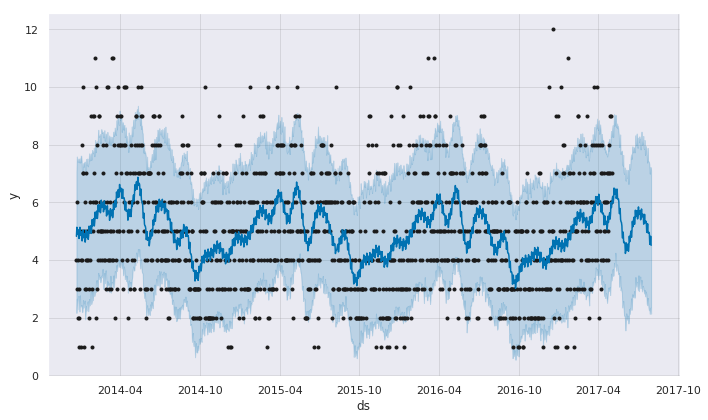

In [97]:
plot_wind1 = model_wind.plot(forecast_wind)

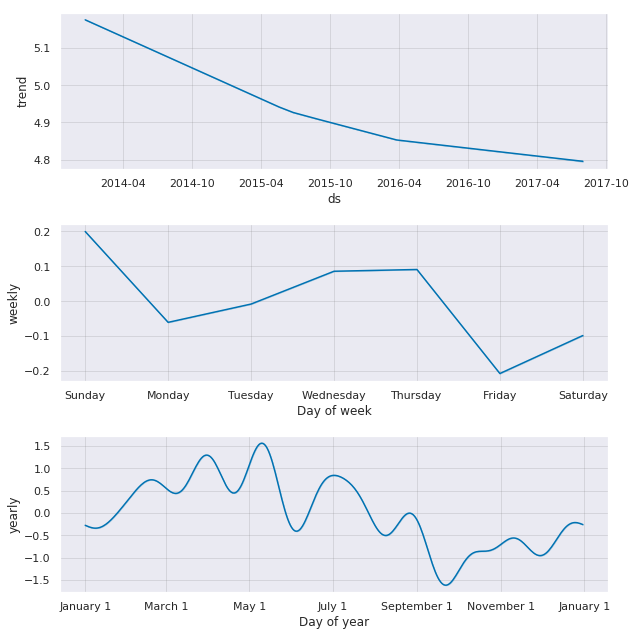

In [98]:
plot_wind2 = model_wind.plot_components(forecast_wind)

In [99]:
analyse_wind_forecast_df = pd.concat([df_wind_test.reset_index(), forecast_wind[1227:]['yhat'].reset_index()], axis=1)
analyse_wind_forecast_df = analyse_wind_forecast_df[['ds','y', 'yhat']]
analyse_wind_forecast_df.set_index('ds', inplace=True)
analyse_wind_forecast_df.tail()

,y,yhat
ds,,
2017-07-27,5,4.902167
2017-07-28,5,4.541553
2017-07-29,4,4.588376
2017-07-30,4,4.825999
2017-07-31,4,4.508021


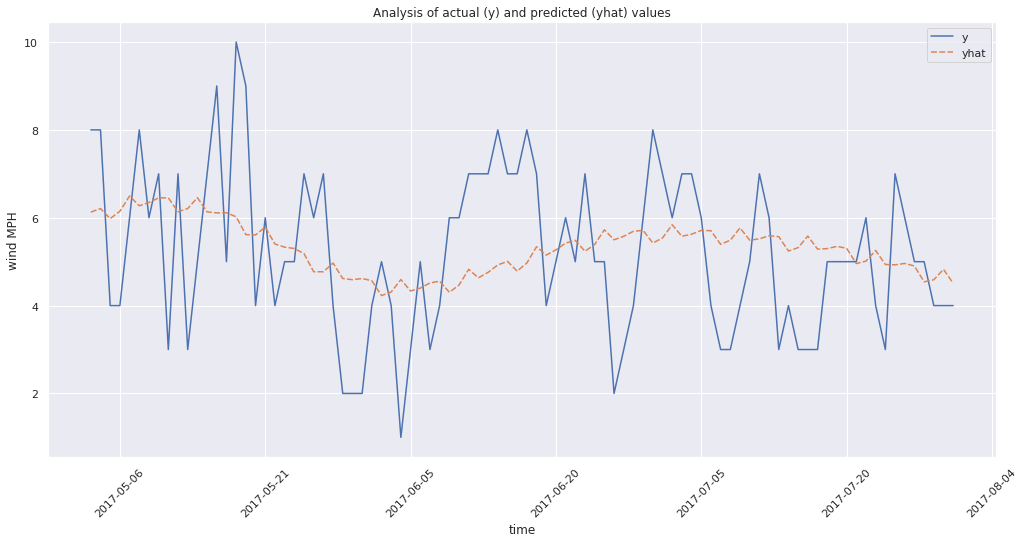

In [100]:
create_line_charts(analyse_wind_forecast_df, 'Analysis of actual (y) and predicted (yhat) values', 'time', 'wind MPH')

In [101]:
mean_absolute_error(analyse_wind_forecast_df['y'], analyse_wind_forecast_df['yhat'])

1.4942409449806222

In [102]:
root_mean_squared_error(analyse_wind_forecast_df['y'], analyse_wind_forecast_df['yhat'])

1.7854589233248432

Now we can forecast into the future, passing the entire dataset to prophet

In [103]:
model_wind2 = Prophet()
model_wind2.fit(df_wind)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [104]:
future_wind2 = model_wind2.make_future_dataframe(periods=180)
future_wind2.tail()

,ds
1492,2018-01-23
1493,2018-01-24
1494,2018-01-25
1495,2018-01-26
1496,2018-01-27


In [0]:
forecast_wind2 = model_wind2.predict(future_wind2)

In [106]:
forecast_wind2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
1487,2018-01-18,4.588749,1.966981,6.835895
1488,2018-01-19,4.368173,1.889665,6.650373
1489,2018-01-20,4.437368,1.865360,7.070043
1490,2018-01-21,4.737249,2.139059,7.338728
1491,2018-01-22,4.513238,2.122287,7.036253
1492,2018-01-23,4.668752,2.203081,7.162777
1493,2018-01-24,4.774998,2.134892,7.207411
1494,2018-01-25,4.815034,2.204575,7.253585
1495,2018-01-26,4.600079,2.112529,7.296538
1496,2018-01-27,4.673545,2.231106,7.041410


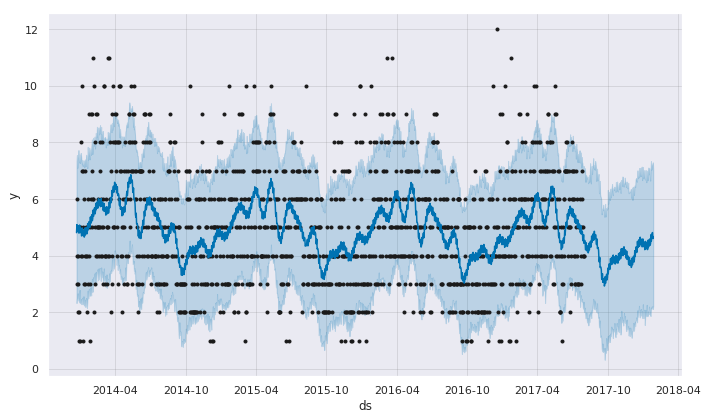

In [107]:
plot_wind3 = model_wind2.plot(forecast_wind2)

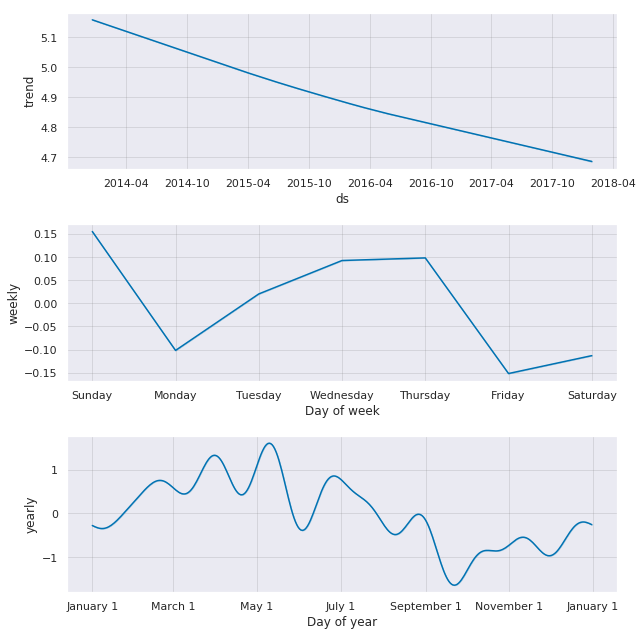

In [108]:
plot_wind4 = model_wind2.plot_components(forecast_wind2)